### 10X: Leave-one-out-Labels

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTconswithoutXX labels:
    * 194 Hom Var
    * 200 Hom Ref
    * 200 Het Var
* **Train/Prediction Label:** GTconswithoutXX


In [2]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



In [3]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/TenX_EM_HR_HG002_DEL_balanced_label_LOO_min1.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/TenX_EM_HR_HG002_DEL_balanced_label_LOO_min1.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,TenX.HP2_amb_reason_orientation_alignmentScore,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_orientation
0,1,HG002,21,65326531,65326651,-120,Deletion,Deletion,0,0,...,1.0,6.0,5.0,529.266667,19.624701,45.0,350.111111,102.531127,45.0,0.0


In [4]:
train_set = pd.DataFrame()
train_set = df_train_2

In [5]:
train_set['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
train_set['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
train_set['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)

<a id='imbalance'></a>

In [6]:
pd.value_counts(train_set['GTconswithoutTenX.GT'].values, sort=False)

0    200
1    200
2    194
dtype: int64

In [7]:
# Train the model only on the rows that have an Exact Match or Homozygous Reference Label
# This step removes any row that has in 'Inaccurate Call' label
df_train = df_train[(df_train['Label'] == 1) | (df_train['Label'] == 0)]
df_train_2 = df_train_2[(df_train_2['Label'] == 1) | (df_train_2['Label'] == 0)]

In [8]:
# There are only Exact Match [1] and Homozygous Reference Labels [0]
pd.value_counts(df_train['Label'].values, sort=False)

0    164
1    430
dtype: int64

<a id='hom_ref'></a>

In [9]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/TenX_HG002_DEL_min1.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/TenX_HG002_DEL_min1.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_insertSizeScore,TenX.HP2_ref_reason_orientation
0,1,HG002,859,37568322,37568587,-115,Insertion,Deletion,0,0,...,24.0,0.0,529.093023,21.757451,43.0,348.418605,115.713606,40.0,0.0,3.0


In [10]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label'}

In [11]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Label'], axis=1, inplace = True)
df_train.drop(['GTcons'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [12]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_alignmentScore,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_orientation
0,1,65326531,65326651,-120,0,0,0,0.0,1,1.0,...,1.0,6.0,5.0,529.266667,19.624701,45.0,350.111111,102.531127,45.0,0.0


In [13]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [14]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTcons',
 'GTsupp',
 'SVtype',
 'TenX.HP1_amb_reason_insertSizeScore_insertSizeScore',
 'TenX.HP1_amb_reason_insertSizeScore_orientation',
 'TenX.HP1_amb_reason_orientation_insertSizeScore',
 'TenX.HP1_ref_reason_insertSizeScore',
 'TenX.HP2_amb_reason_insertSizeScore_insertSizeScore',
 'TenX.HP2_amb_reason_insertSizeScore_orientation',
 'TenX.HP2_amb_reason_orientation_insertSizeScore',
 'TenX.HP2_ref_reason_insertSizeScore',
 'id',
 'sample',
 'type'}

In [15]:
### Drop columns that are not shared by both dataframes
df_test.drop(['TenX.HP1_amb_reason_insertSizeScore_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP1_amb_reason_insertSizeScore_orientation'], axis=1, inplace = True)
df_test.drop(['TenX.HP1_amb_reason_orientation_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP1_ref_reason_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_amb_reason_insertSizeScore_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_amb_reason_insertSizeScore_orientation'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_amb_reason_orientation_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_ref_reason_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['GTconswithoutTenX.GT'], axis=1, inplace = True)
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [16]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_alignmentScore,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_orientation
0,1,65326531,65326651,-120,0,0,0,0.0,1,1.0,...,1.0,6.0,5.0,529.266667,19.624701,45.0,350.111111,102.531127,45.0,0.0
1,1,83753489,83753698,-209,0,0,1,1.0,1,1.0,...,1.0,2.0,1.0,546.700000,11.424097,20.0,380.550000,104.843443,20.0,0.0
2,1,152326749,152326980,-231,0,0,1,1.0,0,0.0,...,1.0,5.0,1.0,544.958333,16.102482,24.0,377.916667,136.597620,22.0,2.0


In [17]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/594 with 0 missing, elapsed time: 0.161
Imputing row 101/594 with 0 missing, elapsed time: 0.206
Imputing row 201/594 with 0 missing, elapsed time: 0.209
Imputing row 301/594 with 0 missing, elapsed time: 0.209
Imputing row 401/594 with 0 missing, elapsed time: 0.210
Imputing row 501/594 with 0 missing, elapsed time: 0.214


In [18]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_alignmentScore,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_orientation
0,1.0,65326531.0,65326651.0,-120.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,6.0,5.0,529.266667,19.624701,45.0,350.111111,102.531127,45.0,0.0
1,1.0,83753489.0,83753698.0,-209.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,2.0,1.0,546.700000,11.424097,20.0,380.550000,104.843443,20.0,0.0
2,1.0,152326749.0,152326980.0,-231.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,5.0,1.0,544.958333,16.102482,24.0,377.916667,136.597620,22.0,2.0


In [19]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['GTconswithoutTenX.GT']

In [20]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

0.0    200
1.0    200
2.0    194
dtype: int64

In [21]:
# Remove labels from feature set
X.drop(['GTconswithoutTenX.GT'],axis=1, inplace = True)

In [22]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.

       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data. The trained model will be used in a [later section](#predict) to predict the consensus GT for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
       * In the following section, svanalyzer data was used to train a random forest (RF) model. The features for the svanalyzer dataset include: svviz features, GA4GH features [RefN, Segmental Duplications, Tandem Repeat], preliminary R script analysis [consensus GT, GTsup].
       * The RF classifier will predict the consensus GT labels:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
       
       * In the [following section](#prediction_step), the trained RF model will be used to predict labels for genotype labels for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]. 

** Train Random Forest Classifier **

<a id='train_test'></a>

In [23]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [24]:
# %%timeit
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [25]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 56 (0.096916)
2. feature 32 (0.087910)
3. feature 4 (0.080833)
4. feature 7 (0.070855)
5. feature 31 (0.066772)
6. feature 6 (0.061530)
7. feature 34 (0.057486)
8. feature 3 (0.054382)
9. feature 25 (0.047495)
10. feature 24 (0.034790)
11. feature 5 (0.030633)
12. feature 53 (0.030484)
13. feature 2 (0.027202)
14. feature 33 (0.021733)
15. feature 28 (0.019805)
16. feature 52 (0.019097)
17. feature 1 (0.016906)
18. feature 54 (0.014304)
19. feature 26 (0.011677)
20. feature 55 (0.010849)
21. feature 48 (0.009354)
22. feature 10 (0.009336)
23. feature 17 (0.009225)
24. feature 35 (0.008448)
25. feature 50 (0.007174)
26. feature 40 (0.006273)
27. feature 47 (0.006022)
28. feature 12 (0.005559)
29. feature 38 (0.005481)
30. feature 30 (0.004650)
31. feature 59 (0.004641)
32. feature 51 (0.004326)
33. feature 45 (0.004259)
34. feature 14 (0.004198)
35. feature 22 (0.004115)
36. feature 43 (0.003974)
37. feature 15 (0.003939)
38. feature 41 (0.003856)
39. feature

[Another Resource](https://stackoverflow.com/questions/37877542/how-to-label-the-feature-importance-with-forests-of-trees)

<a id='feature_importance'></a>

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



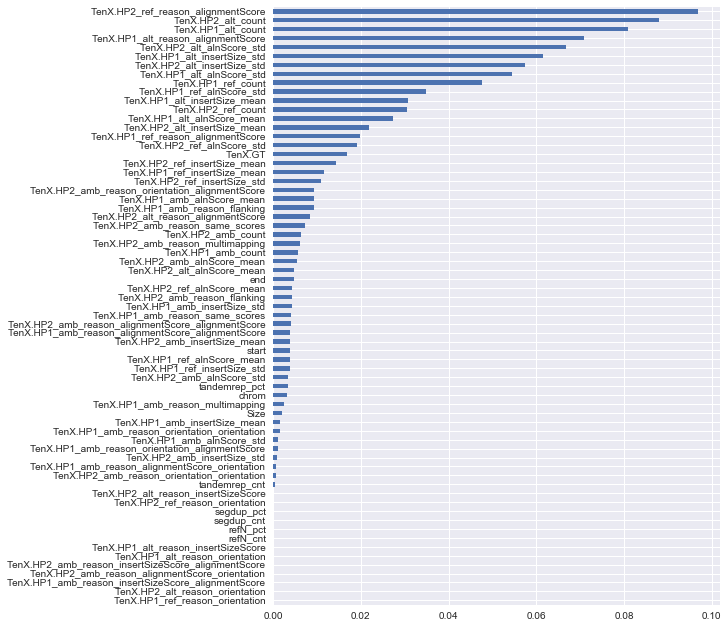

In [30]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(8,11))

In [31]:
#TODO: Try training the model with the most important features and note difference in overal model prediction score

In [31]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

0.0    150
1.0    131
2.0    134
dtype: int64

<a id='prediction_step'></a>

In [32]:
pred = model.predict(X_test)

<a id='traintest_precision'></a>

In [33]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(pred, y_test, average='micro'))) 

Precision score of the training subset: 0.855


In [34]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Size,TenX.GT,TenX.HP1_alt_alnScore_mean,TenX.HP1_alt_alnScore_std,TenX.HP1_alt_count,TenX.HP1_alt_insertSize_mean,TenX.HP1_alt_insertSize_std,TenX.HP1_alt_reason_alignmentScore,TenX.HP1_alt_reason_insertSizeScore,TenX.HP1_alt_reason_orientation,...,TenX.HP2_ref_reason_orientation,chrom,end,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
240,-22.0,-1.0,522.750000,14.914339,8.0,359.875,80.770412,8.0,0.0,0.0,...,0.0,1.0,238908601.0,0.0,0.0,0.0,0.0,238908578.0,1.0,1.000000
132,-28.0,0.0,525.000000,0.000000,1.0,288.000,0.000000,1.0,0.0,0.0,...,0.0,10.0,110381979.0,0.0,0.0,0.0,0.0,110381951.0,1.0,0.928571
424,-339.0,-1.0,522.944444,21.101533,18.0,389.500,80.988511,11.0,7.0,0.0,...,0.0,10.0,92969541.0,0.0,0.0,0.0,0.0,92969202.0,2.0,0.112094
92,-21.0,0.0,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,...,0.0,10.0,3928410.0,0.0,0.0,0.0,0.0,3928388.0,1.0,1.000000
170,-50.0,0.0,529.000000,0.000000,1.0,235.000,0.000000,1.0,0.0,0.0,...,0.0,11.0,83841586.0,0.0,0.0,0.0,0.0,83841535.0,1.0,1.000000


In [35]:
labels = pd.DataFrame(y_test)

In [36]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTconswithoutTenX.GT'] = df_train['GTconswithoutTenX.GT']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [37]:
df_Xtest['GTconswithoutTenX.GT'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['GTconswithoutTenX.GT'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['GTconswithoutTenX.GT'].replace(2.0, 'Homozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [38]:
pd.value_counts(df_Xtest['GTconswithoutTenX.GT'].values, sort=False)

Heterozygous_Variant    69
Homozygous_Reference    50
Homozygous_Variant      60
dtype: int64

In [39]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

Heterozygous_Variant    55
Homozygous_Reference    63
Homozygous_Variant      61
dtype: int64

In [40]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTconswithoutTenX.GT']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[50 11  8]
 [ 0 50  0]
 [ 5  2 53]]


<a id='traintest_confusion_matrix'></a>

In [41]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,50,11,8,69
Homozygous_Reference,0,50,0,50
Homozygous_Variant,5,2,53,60
All,55,63,61,179


In [42]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.91      0.72      0.81        69
Homozygous_Reference       0.79      1.00      0.88        50
  Homozygous_Variant       0.87      0.88      0.88        60

         avg / total       0.86      0.85      0.85       179



***
Predict
***

<a id='predict'></a>

Description:

   * In the [previous section](#machine_learning), a RF model was trained on svanalyzer data.

       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
 * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are the consensus genotype (GTcons) labels generated from a preliminary R analysis based on reference and alternate read count:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

** Load Data **

In [43]:
X2 = df_test

** Impute missing values using KNN **

In [44]:
#Convert dataframe to matrix
X2=X2.as_matrix()
X2=pd.DataFrame(X2)

# Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/4003 with 0 missing, elapsed time: 6.926
Imputing row 101/4003 with 0 missing, elapsed time: 6.933
Imputing row 201/4003 with 0 missing, elapsed time: 6.936
Imputing row 301/4003 with 0 missing, elapsed time: 6.939
Imputing row 401/4003 with 0 missing, elapsed time: 6.946
Imputing row 501/4003 with 0 missing, elapsed time: 6.950
Imputing row 601/4003 with 0 missing, elapsed time: 6.953
Imputing row 701/4003 with 0 missing, elapsed time: 6.955
Imputing row 801/4003 with 57 missing, elapsed time: 6.985
Imputing row 901/4003 with 0 missing, elapsed time: 6.998
Imputing row 1001/4003 with 0 missing, elapsed time: 6.999
Imputing row 1101/4003 with 0 missing, elapsed time: 7.007
Imputing row 1201/4003 with 0 missing, elapsed time: 7.010
Imputing row 1301/4003 with 0 missing, elapsed time: 7.010
Imputing row 1401/4003 with 0 missing, elapsed time: 7.014
Imputing row 1501/4003 with 0 missing, elapsed time: 7.014
Imputing row 1601/4003 with 57 missing, elapsed time: 7.083
Imputin

In [45]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_alignmentScore,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.000000,3.0,0.818868,...,16.0,24.0,0.0,529.093023,21.757451,43.0,348.418605,115.713606,40.0,3.0
1,1.0,112835104.0,112837661.0,-2534.0,0.0,0.0,1.0,0.890888,6.0,0.460305,...,0.0,7.0,0.0,546.000000,0.000000,1.0,552.000000,0.000000,1.0,0.0
2,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.000000,1.0,1.000000,...,0.0,23.0,8.0,509.400000,14.921126,5.0,381.400000,88.703100,5.0,0.0


In [46]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,TenX.HP2_amb_reason_orientation_alignmentScore,TenX.HP2_amb_reason_orientation_orientation,TenX.HP2_amb_reason_same_scores,TenX.HP2_ref_alnScore_mean,TenX.HP2_ref_alnScore_std,TenX.HP2_ref_count,TenX.HP2_ref_insertSize_mean,TenX.HP2_ref_insertSize_std,TenX.HP2_ref_reason_alignmentScore,TenX.HP2_ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.000000,3.0,0.818868,...,16.0,24.0,0.0,529.093023,21.757451,43.0,348.418605,115.713606,40.0,3.0
1,1.0,112835104.0,112837661.0,-2534.0,0.0,0.0,1.0,0.890888,6.0,0.460305,...,0.0,7.0,0.0,546.000000,0.000000,1.0,552.000000,0.000000,1.0,0.0
2,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.000000,1.0,1.000000,...,0.0,23.0,8.0,509.400000,14.921126,5.0,381.400000,88.703100,5.0,0.0


In [47]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [ ]:

# X5 = df_test

<a id='prediction_step'></a>

In [48]:
pred = model.predict(X5)

In [49]:
pred_prob = model.predict_proba(X5)

In [50]:
pred_prob_log = model.predict_log_proba(X5)

In [51]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['GTcons'] = df_test_2['GTcons']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTconswithoutTenX.GT'] = df_test_2['GTconswithoutTenX.GT']
X5['GTsupp'] = df_test_2['GTsupp']

In [52]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [53]:
X7 = pd.concat([X5, pd.DataFrame(pred_prob_log, columns=['1','2','3'])])

In [54]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/TenX_pred_prob_DEL_revisedR_LOO.csv', index=False)

In [55]:
X7.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/TenX_pred_prob_log_DEL_revisedR_LOO.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [56]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/TenX_pred_prob_DEL_revisedR_LOO.csv')

In [57]:
X6.rename(columns={'1': 'Homozygous_Reference_LOO_TenX'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant_LOO_TenX'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant_LOO_TenX'}, inplace=True)
X6.rename(columns={'predicted_label': 'TenX_predicted_LOO_label'}, inplace=True)

In [58]:
X6.head(3)

,Homozygous_Reference_LOO_TenX,Heterozygous_Variant_LOO_TenX,Homozygous_Variant_LOO_TenX,GTcons,GTconswithoutTenX.GT,GTsupp,Size,TenX.GT,TenX.HP1_alt_alnScore_mean,TenX.HP1_alt_alnScore_std,...,chrom,end,TenX_predicted_LOO_label,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,0.8,0.2,0.0,0,0,4,-115,0.0,0.000000,0.000000,...,1,37568587,0,0,0,0,0.000000,37568322,3,0.818868
1,0.1,0.1,0.8,2,2,1,-2534,-1.0,548.833333,8.394774,...,1,112837661,2,0,0,1,0.890888,112835104,6,0.460305
2,0.1,0.8,0.1,1,1,1,-40,-1.0,0.000000,0.000000,...,1,1092715,1,0,0,0,0.000000,1092675,1,1.000000


In [59]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/TenX_final_GTcons_LOO_DEL_SVanalyzer.csv', index=False)

***
Label Analysis
***

Description:
  * The [random forest(RF) model](#train_test) was trained on svanalyzer data. The trained model was used to predict consensus GT labels for the 5000 deletions that were randomly selected from the union_refalt vcf. The following is a comparison of model predicted labels [Conesus GT] to consensus genotype generated by the R script for the 5000 randomly selected datapoints from union_refalt.vcf 

In [60]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTconswithoutTenX.GT']
predict = X6['TenX_predicted_LOO_label']
print(confusion_matrix(consensus_GT, predict))

[[ 758   62   45]
 [ 188 1755  297]
 [  27   76  795]]


In [61]:
X6['GTconswithoutTenX.GT'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTconswithoutTenX.GT'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTconswithoutTenX.GT'].replace(2, 'Homozygous_Variant', inplace=True)
X6['TenX_predicted_LOO_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
X6['TenX_predicted_LOO_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
X6['TenX_predicted_LOO_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

<a id='predict_precision_score_matrix'></a>

In [63]:
print('Precision score of the prediction subset: {:.3f}'.format(precision_score(consensus_GT, predict, average='micro'))) 

Precision score of the prediction subset: 0.826


In [62]:
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,1755,188,297,2240
Homozygous_Reference,62,758,45,865
Homozygous_Variant,76,27,795,898
All,1893,973,1137,4003


** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following consensus genotype:
    * Homozygous Reference: 0 
    * Heterozygous Variant: 1 
    * Homozygous Variant: 2 
* Here **high confidence labels** are the LOO GTcons labels predicted by the model that were also assigned a predict probability of either 0.9 or 1

In [64]:
high_conf_labels = X6[(X6['Homozygous_Reference_LOO_TenX'] == 1) | (X6['Homozygous_Reference_LOO_TenX'] == 0.9) | (X6['Heterozygous_Variant_LOO_TenX'] == 1) | (X6['Heterozygous_Variant_LOO_TenX'] == 0.9) | (X6['Homozygous_Variant_LOO_TenX'] == 1) | (X6['Homozygous_Variant_LOO_TenX'] == 0.9)]


<a id='hiconf_precision_score'></a>

In [65]:
consensus_GT = high_conf_labels['GTconswithoutTenX.GT']
predict = high_conf_labels['TenX_predicted_LOO_label']
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,1079,34,73,1186
Homozygous_Reference,7,576,10,593
Homozygous_Variant,11,6,626,643
All,1097,616,709,2422


In [66]:
from sklearn.metrics import classification_report
print(classification_report(consensus_GT, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.98      0.91      0.95      1186
Homozygous_Reference       0.94      0.97      0.95       593
  Homozygous_Variant       0.88      0.97      0.93       643

         avg / total       0.94      0.94      0.94      2422

